In [1]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

#Kmeans clustering experiment imports
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#tf.debugging.set_log_device_placement(True)

In [2]:
# Change me for other classifications!
# --------------------------------------------------
SCOPE = 'binary'
DATASET = 'nslkdd'
# --------------------------------------------------

# Our options to test
SCOPES = ('binary', 'categories', 'types')
DATASETS = ('kdd99', '10%kdd99', 'nslkdd')

In [3]:
'''
CONSTANTS & PROGRAM SET UP: 
To switch between binary (2), categories (5), and types (23) classifications.
'''

# Check program parameters
if SCOPE not in SCOPES:
    raise Exception(f'Please pick from available scopes: {SCOPES}. (Input: {SCOPE})')
elif DATASET not in DATASETS:
    raise Exception(f'Please pick from available datasets: {DATASETS}. (Input: {DATASET})')

# Categories
DOS_TYPES = ('back','land','neptune','pod','smurf','teardrop')
U2R_TYPES = ('buffer_overflow','loadmodule','perl','rootkit')
R2L_TYPES = ('ftp_write','guess_passwd','imap','multihop','phf','spy','warezclient','warezmaster')
PROBE_TYPES = ('ipsweep','nmap','portsweep','satan')


# For categorical conversion of outcome - dictionaries are fast
attack_dict = dict(normal ='normal')
[attack_dict.setdefault(each, 'dos') for each in DOS_TYPES]
[attack_dict.setdefault(each, 'u2r') for each in U2R_TYPES]
[attack_dict.setdefault(each, 'r2l') for each in R2L_TYPES]
[attack_dict.setdefault(each, 'probe') for each in PROBE_TYPES]


# For our methods to handle the correct number of classifications
num_classifications = {'binary' : 2, 'categories' : 5, 'types' : 23}

try:
    N_CLASS = num_classifications[SCOPE]
except KeyError as ke:
    print('Scope chosen does not match available options (check spelling)')

In [4]:
# Choose Dataset and format DF as appropriate

try:
    if DATASET == 'kdd99':
        path = get_file('kddcup.data.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz')
    elif DATASET == '10%kdd99':
        path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
    elif DATASET == 'nslkdd':
        path = './nslkdd/KDDTrain+.txt'
    else:
        raise Exception
except:
    print('Error downloading')
    raise
    
df = pd.read_csv(path, header=None)
print("Read {} rows into dataframe.".format(len(df)))

# Sample only 1% of the dataset
#df = df.sample(frac=0.01, replace=False)

# Drop NA's (rows with missing values)
df.dropna(inplace=True,axis=1) 

columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

if path == './nslkdd/KDDTrain+.txt':
    columns.append('difficulty_rating')
    
df.columns = columns


Read 125973 rows into dataframe.


In [5]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Binary Classification
def set_bin_class(df):
    for i, row in df.iterrows():
        if row['outcome'].split('.')[0] != 'normal':
            df.at[i, 'outcome'] = 1
        else:
            df.at[i, 'outcome'] = 0

# Categorical Attack Classification
def set_category_class(df):
    for i, row in df.iterrows():
        val = row['outcome'].split('.')[0]
        df.at[i, 'outcome'] = attack_dict[val]
    return    

# Supports sampling
def convert_to_numpy(df_trainer):
    # Convert to numpy - Classification
    x_columns = df_trainer.columns.drop(class_columns)
    x = df_trainer[x_columns].values
    dummies = pd.get_dummies(df_trainer['outcome']) # Classification

    outcomes = dummies.columns
    num_classes = len(outcomes)
    y = dummies.values
    return x, y, num_classes

In [6]:
# Quantitative - numeric/continuous values
to_zscore = ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 
            'hot', 'num_failed_logins', 'num_compromised', 'root_shell', 
            'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
            'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 
            'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
            'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
            'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 
            'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 
            'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
            'dst_host_srv_rerror_rate']

# Qualitative - nominal/binary features
to_dummy = ['protocol_type',
            'service',
            'flag',
            'land',
            'logged_in',
            'is_host_login',
            'is_guest_login']

# depending on the dataset we test, this handles additional classification columns
class_columns = set(columns) - set(to_zscore) - set(to_dummy)
class_columns = list(class_columns)

In [7]:
# CHECK: display 5 rows & classification counts in dataset
# print(df[0:5])
# print(df['outcome'].nunique())
# print(df.groupby('outcome')['outcome'].count())

In [8]:
# Transformations: Encode the feature vector
for each in to_zscore: encode_numeric_zscore(df, each)
for each in to_dummy: encode_text_dummy(df, each)
    
# Drop missing data
df.dropna(inplace=True,axis=1)

# Format outcome for appropriate classification
if SCOPE == 'binary': set_bin_class(df)
elif SCOPE == 'categories': set_category_class(df)
elif SCOPE == 'types': pass

# Numeric feature vector
df_trainer = None

# Sampling method to include all classifications of interest
num_classes = 0
while num_classes != N_CLASS: 
                                                    # do we still want this (comment)? 
    df_trainer = df.sample(frac=1.0, replace=False) # Uncomment this line to sample only 10% of the dataset
    x, y, num_classes = convert_to_numpy(df_trainer)

print(f'Performing {SCOPE.upper()} Classification')

Performing BINARY Classification


In [9]:
'''Create tests and training sets'''
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25)

In [ ]:
'''NEURAL NETWORK'''
def baseline_model():
    '''
    'linear' - activation takes weights*input and outputs signal proportional to the input
    'softmax' - normalized exponential activation (large input = much larger output)
    'adam' - extension to stochastic gradient descent
    '''
    model = Sequential()
    model.add(Dense(32, input_dim=x.shape[1], activation='linear'))
    model.add(Dense(32, input_dim=x.shape[1], activation='linear'))
    model.add(Dense(y.shape[1], activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=50, verbose=0)

In [ ]:
# Train NN
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
estimator.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=50)

In [ ]:
# Evaluate Success of NN
import numpy as np
from sklearn import metrics

def validation_score(x, y):
    y_eval = np.argmax(y, axis=1)
    pred = estimator.predict(x)
    score = metrics.accuracy_score(y_eval, pred)
    print("Validation score: {}".format(score))
    return score

In [ ]:
validation_score(x_test, y_test)

In [ ]:
validation_score(x, y)

In [ ]:
'''RANDOM FOREST'''

#from sklearn.neural_network import MLPClassifier
#mlp = MLPClassifier(hidden_layer_sizes=(64,64,),max_iter=50,verbose=True)
#mlp.fit(x_train, y_train)

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, verbose=1)
rfc.fit(x_train, y_train)
predictions = rfc.predict(x_test)

In [ ]:
results = []
for val in y:
    results.append(val[0])

In [ ]:
import warnings
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

PC1 = 'principal component 1'
PC2 = 'principal component 2'

def PCA_method():
    # CHECK 
    #predictions = mlp.predict(x_test)
    #print(confusion_matrix(y_test, predictions))
    #print(classification_report(y_test,predictions))
    
    pca = PCA(n_components = 2)
    principalComponents = pca.fit_transform(x_test)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = [PC1, PC2])

    '''
    prepares true_normal_df for visualization; to compare against 
    the two groups generated by K-Means Clustering.
    '''
    true_normal_df = principalDf.copy()                                                     #copy PCA1, PCA2 columns from principalDf (original df) into new true_normal_df
    true_normal_df['outcome'] = results                                                     #copy outcome column from original df to true_normal_df
    true_normal_df = true_normal_df.drop(true_normal_df[true_normal_df.outcome != 1].index) #delete all rows from true_normal_df with outcome != 'normal'
    true_normal_df.drop(['outcome'], axis = 1)                                              #drop outcome column from the true_normal_df, 
                                                                                            #leaves PCA1 & PCA2 cols that correspond to true normal rows (for plot)
    # CHECK - every outcome in our table is normal
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        outcome_count = len(true_normal_df['outcome'])
        normal_count = (true_normal_df.outcome == 'normal').sum()
        print(outcome_count, normal_count == 0 or normal_count == outcome_count) 
    return principalDf, true_normal_df


In [ ]:
if SCOPE == 'binary':
    principalDf, true_normal_df = PCA_method()
    
    # Plot PCA
    scatter = plt.scatter(principalDf[PC1], principalDf[PC2], c = results, cmap = 'viridis')
    plt.scatter(true_normal_df[PC1], true_normal_df[PC2], color = 'g', alpha = 1)
    plt.show()

In [ ]:
### K-Means clustering on KDD99 dataset

In [11]:

x_df = df.dropna(axis=1)
x_df = df.drop(columns=['outcome'])


In [13]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_df)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])



In [14]:
km = KMeans(n_clusters = 2)
km.fit(principalDf)
y_kmeans = km.predict(principalDf)

In [15]:
true_normal_df = principalDf.copy()
true_normal_df['outcome'] = df['outcome']
true_normal_df = true_normal_df.drop(true_normal_df[true_normal_df.outcome != 0].index) #delete all rows from true_normal_df with outcome != 'normal'
true_normal_df.drop(['outcome'], axis = 1, inplace=True) #finally, drop the outcome column from the true_normal_df, and we are left with PCA1 and PCA2 cols that correspond to the true normal rows, so we can plot and visualize these in the next step

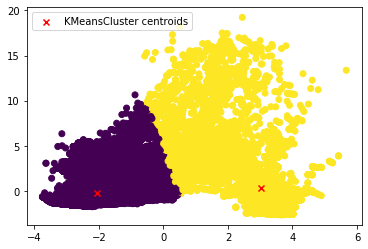

In [31]:
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c = y_kmeans, cmap = 'viridis')
centers = np.array(km.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r', label = 'KMeansCluster centroids')
plt.legend(loc="upper left")
# Below we see the result of splitting the dataset into 2 clusters using KMeans Clusters.
# On the left is normal data, on the right is anomaly data
fname = "KMeansClusters_"+DATASET+"_"+SCOPE
plt.savefig(fname)
plt.show()

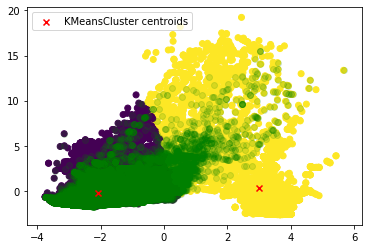

In [33]:
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c = y_kmeans, cmap = 'viridis')
centers = np.array(km.cluster_centers_)
plt.scatter(true_normal_df['principal component 1'], true_normal_df['principal component 2'], color = 'g', alpha = 0.15)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r', label = 'KMeansCluster centroids')
plt.legend(loc="upper left")
# Below we see the result of splitting the dataset into 2 clusters using KMeans Clusters.
# On the left is normal data, on the right is anomaly data
# We can confirm that the left is normal data by overlaying it with the values found in true_normal_df
fname = "KMeansClusters_Normal_"+DATASET+"_"+SCOPE
plt.savefig(fname)
plt.show()

In [21]:
#Check accuracy of the Kmeans clustering predicted values. To do this:

#check alignment between the y_kmeans (which are the Kmeans predicted values) and one of the two clusters. 

#there are two possible ways that Kmeans_predicted_values could have been encoded. 1's may represent normal, or 1's may represent abnormal
#Below, we will check both possibilites, and return the case which matches our true binary_encoded_outcome.
binary_encoded_outcome = df['outcome'].apply(lambda x: 1 if x == 0 else 0 )

#comparison_df will be used to compare the two possible binary encodings of "normal" from y_kmeans with the true outcome encoded in binary (called Binary_encoded_outcome)
comparison_df = pd.DataFrame()
comparison_df['Binary_encoded_outcome'] = binary_encoded_outcome
comparison_df['Kmeans_predicted_A'] = y_kmeans

comparison_df['Kmeans_predicted_B'] = comparison_df['Kmeans_predicted_A'].apply(lambda x: 0 if x == 1 else 1 ) #flip 0s and 1's

total_true_values = len(df['outcome'])

if (comparison_df['Binary_encoded_outcome'] == comparison_df['Kmeans_predicted_A']).sum() > (comparison_df['Binary_encoded_outcome'] == comparison_df['Kmeans_predicted_B']).sum():
    principalDf['Kmeans_predicted'] = comparison_df['Kmeans_predicted_A']
else:
    principalDf['Kmeans_predicted'] = comparison_df['Kmeans_predicted_B']

principalDf['true_outcome'] = binary_encoded_outcome

correctly_predicted = (principalDf['Kmeans_predicted'] == principalDf['true_outcome']).sum()
print('Kmeans correctly predicted', correctly_predicted, 'out of', total_true_values, 'Accuracy: ', round(correctly_predicted/total_true_values, 3) * 100, '%')


Kmeans correctly predicted 114793 out of 125973 Accuracy:  91.10000000000001 %
